In [1]:
import sys
from loguru import logger
from pathlib import Path
import numpy as np
import pandas as pd
import keras
from keras.models import load_model,clone_model
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

sys.path.append("../imports/")
import custom_variables as custom_paths
import metrics as met

2025-12-17 16:36:08.958380: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 16:36:10.674226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 16:36:16.552202: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
df = pd.read_csv(custom_paths.csv_path)
df = df[(df["CLASS_GENERIC"] == "AGN") | (df["CLASS_GENERIC"] == "Pulsar")]
print(f"Sample Size: {len(df)}")

Sample Size: 4334


In [3]:
col_input1 = ["GLAT","Variability_Index" ,"PowerLaw","LogParabola","PLSuperExpCutoff"]
col_flux_band = np.array([[f"Flux_Band_{i}", f"Sqrt_TS_Band_{i}"] for i in range(8)])
col_flux_hist = np.array([[f"Flux_History_{i}", f"Sqrt_TS_History_{i}"] for i in range(14)])

In [4]:
norm_cols = np.array(list(col_flux_band.flatten()) + list(col_flux_hist.flatten()))
scaler = StandardScaler()
scaler.fit(df[norm_cols])
scaled_data = scaler.transform(df[norm_cols])
df[norm_cols] = scaled_data

In [5]:
input_additional = df[col_input1].to_numpy()
input_flux_band = df[col_flux_band.flatten()].to_numpy()
input_flux_hist = df[col_flux_hist.flatten()].to_numpy()
print(f"Additionl Size: {input_additional.shape}")
print(f"Flux_Band Size: {input_flux_band.shape}")
print(f"Flux_History Size: {input_flux_hist.shape}")

Additionl Size: (4334, 5)
Flux_Band Size: (4334, 16)
Flux_History Size: (4334, 28)


In [6]:
is_agn = df["CLASS_GENERIC"].to_numpy() == "AGN"
labels = np.zeros((len(df)), dtype=int)
labels[~is_agn] = 1

In [7]:
splitdata = StratifiedKFold(n_splits=4, shuffle=True)
train, test = next(splitdata.split(np.zeros(len(labels)), labels))

fb = input_flux_band[train]
hb = input_flux_hist[train]
ia = input_additional[train]
lab = labels[train]
vfb =  input_flux_band[test]
vhb =  input_flux_hist[test]
via = input_additional[test]
vlab = labels[test]

In [8]:
history_array = []

loss_k_array = []
auc_k_array = []
accuracy_k_array = []
acc_agn_k_array = []
acc_psr_k_array = []
eq_th_k_array =[]
eq_acc_agn_k_array = []
eq_acc_psr_k_array = []
f1_k_array = []
th_k_array = []
roc_k_array = []
cm_k_array = []

loss_all_array = []
auc_all_array = []
accuracy_all_array = []
acc_agn_all_array = []
acc_psr_all_array = []
eq_th_all_array = []
eq_acc_agn_all_array = []
eq_acc_psr_all_array = []
f1_all_array = []
th_all_array = []
roc_all_array = []
cm_all_array = []

In [10]:
model_path = (
    custom_paths.dir_models_path
    / "Risultati_Terza_Esecuzione"
    / f"TripleFolf0.keras"
)

In [11]:
reset_model = load_model(model_path)

2025-12-17 16:36:38.376085: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
reset_model.layers[6].rate

0.4

In [9]:
fold_no = 0
skf = StratifiedKFold(n_splits=10, shuffle=True)
for ktrain, ktest in skf.split(np.zeros(len(lab)), lab):
    k_hb = hb[ktrain]
    k_fb = fb[ktrain]
    k_ia = ia[ktrain]
    k_lab = lab[ktrain]
    k_vfb = fb[ktest]
    k_vhb = hb[ktest]
    k_via = ia[ktest]
    k_vlab = lab[ktest]

    model_path = (
        custom_paths.dir_models_path
        / "Risultati_Terza_Esecuzione"
        / f"TripleFolf{fold_no}.keras"
    )
    reset_model = load_model(model_path)

    print(f"Fold No.{fold_no}")
    #print("------------------------------------------------------------------------")
    #print("Prediction on Fold")
    scores = reset_model.evaluate([k_vfb, k_vhb, k_via], k_vlab)
    predictions = reset_model.predict([k_vfb, k_vhb, k_via])

    loss_k_array.append(scores[0])
    auc_k_array.append(scores[1])
    #print(f"Loss: {scores[0]}")
    #print(f"AUC {scores[2]}")

    acc, th = met.best_accuracy(k_vlab, predictions)
    accuracy_k_array.append(acc)
    th_k_array.append(th)
    #print(f"Accuracy: {acc}")

    f1_score = met.f1_score(th, k_vlab, predictions)
    f1_k_array.append(f1_score)
    #print(f"F1 Score: {f1_score}")

    acc_agn, acc_psr = met.class_accuracy(th, k_vlab, predictions)
    acc_agn_k_array.append(acc_agn)
    acc_psr_k_array.append(acc_psr)
    #print(f"Accuracy AGN: {acc_agn} Accuracy PSR: {acc_psr}")

    roc_points = met.roc_curve(k_vlab, predictions)
    roc_k_array.append(roc_points)

    th_pred = (predictions >= th).astype(int)
    cm_sing = met.sk_metrics.confusion_matrix(k_vlab, th_pred)
    #print(cm_sing)
    cm_k_array.append(cm_sing)

    #print("------------------------------------------------------------------------")

    #print("Prediction on Evaluation Dataset")
    scores = reset_model.evaluate([vfb, vhb, via], vlab)
    predictions = reset_model.predict([vfb, vhb, via])

    loss_all_array.append(scores[0])
    auc_all_array.append(scores[1])
    #print(f"Loss: {scores[0]}")
    #print(f"AUC {scores[2]}")

    acc, th = met.best_accuracy(vlab, predictions)
    accuracy_all_array.append(acc)
    th_all_array.append(th)
    #print(f"Accuracy: {acc}")

    f1_score = met.f1_score(th, vlab, predictions)
    f1_all_array.append(f1_score)
    #print(f"F1 Score: {f1_score}")

    acc_agn, acc_psr = met.class_accuracy(th, vlab, predictions)
    acc_agn_all_array.append(acc_agn)
    acc_psr_all_array.append(acc_psr)
    #print(f"Accuracy AGN: {acc_agn} Accuracy PSR: {acc_psr}")

    roc_points = met.roc_curve(vlab, predictions)
    roc_all_array.append(roc_points)

    th_pred = (predictions >= th).astype(int)
    cm_sing = met.sk_metrics.confusion_matrix(vlab, th_pred)
    print(cm_sing)
    cm_all_array.append(cm_sing)
    #print("------------------------------------------------------------------------")
    fold_no = fold_no + 1
# end for
roc_k_array = np.array(roc_k_array)
roc_all_array = np.array(roc_all_array)
cm_k_array = np.array(cm_k_array)
cm_all_array = np.array(cm_all_array)

2025-12-15 17:51:49.186507: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold No.0
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9928 - auc: 0.9145 - loss: 0.0202      
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9909 - auc: 0.9992 - loss: 0.0175
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[999   5]
 [  5  75]]
Fold No.1


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9933 - auc: 0.9909 - loss: 0.0235      
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - auc: 0.9990 - loss: 0.0186
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[1001    3]
 [   8   72]]
Fold No.2


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9892 - auc: 0.9981 - loss: 0.0367  
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9893 - auc: 0.9972 - loss: 0.0351
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[997   7]
 [  8  72]]
Fold No.3


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9920 - auc: 0.9965 - loss: 0.0293  
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9903 - auc: 0.9985 - loss: 0.0260
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[998   6]
 [  9  71]]


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold No.4
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9905 - auc: 0.8302 - loss: 0.0253    
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9937 - auc: 0.9990 - loss: 0.0167
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[997   7]
 [  6  74]]


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold No.5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9924 - auc: 0.9980 - loss: 0.0268
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9937 - auc: 0.9989 - loss: 0.0219
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[1002    2]
 [   9   71]]


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold No.6
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9975 - auc: 0.9153 - loss: 0.0143    
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9949 - auc: 0.9991 - loss: 0.0156
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[999   5]
 [  6  74]]


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold No.7
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0084    
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - auc: 0.9990 - loss: 0.0169
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[1002    2]
 [   8   72]]
Fold No.8


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9891 - auc: 0.8311 - loss: 0.0324      
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9926 - auc: 0.9991 - loss: 0.0196
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[1002    2]
 [  10   70]]


/home/aelita/Progetto_Computings/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 43 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold No.9
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9868 - auc: 0.8269 - loss: 0.0340          
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9954 - auc: 0.9989 - loss: 0.0160
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[1002    2]
 [   9   71]]


In [10]:
print(f"Best Model Was: {np.argmax(f1_all_array)}. Based on F1Score")
print("------------------------------------------------------------------------\n")
print("Average scores for all folds:")
print("Prediction on Fold")
print(f"> Loss: {np.mean(loss_k_array)}(+- {np.std(loss_k_array)})")
print(f"> AUC: {np.mean(auc_k_array)} (+- {np.std(auc_k_array)})")
print(f"> Accuracy: {np.mean(accuracy_k_array)} (+- {np.std(accuracy_k_array)})")
print(f"> F1: {np.mean(f1_k_array)} (+- {np.std(f1_k_array)})")
print(f"> Acc AGN: {np.mean(acc_agn_k_array)} (+- {np.std(acc_agn_k_array)})")
print(f"> Acc PSR: {np.mean(acc_psr_k_array)} (+- {np.std(acc_psr_k_array)})")
print("Confution Matrix")
print(f"{np.mean(cm_k_array[:,0,0])}+-{np.std(cm_k_array[:,0,0])}\t{np.mean(cm_k_array[:,0,1])}+-{np.std(cm_k_array[:,0,1])}")
print(f"{np.mean(cm_k_array[:,1,0])}+-{np.std(cm_k_array[:,1,0])}\t{np.mean(cm_k_array[:,1,1])}+-{np.std(cm_k_array[:,1,1])}")
print("--------------------------------------------------------")
print("Prediction on Evaluation DataSet")
print(f"> Loss: {np.mean(loss_all_array)}(+- {np.std(loss_all_array)})")
print(f"> AUC: {np.mean(auc_all_array)} (+- {np.std(auc_all_array)})")
print(f"> Accuracy: {np.mean(accuracy_all_array)} (+- {np.std(accuracy_all_array)})")
print(f"> F1: {np.mean(f1_all_array)} (+- {np.std(f1_all_array)})")
print(f"> Acc AGN: {np.mean(acc_agn_all_array)} (+- {np.std(acc_agn_all_array)})")
print(f"> Acc PSR: {np.mean(acc_psr_all_array)} (+- {np.std(acc_psr_all_array)})")
print("Confution Matrix")
print(f"{np.mean(cm_all_array[:,0,0])}+-{np.std(cm_all_array[:,0,0])}\t{np.mean(cm_all_array[:,0,1])}+-{np.std(cm_all_array[:,0,1])}")
print(f"{np.mean(cm_all_array[:,1,0])}+-{np.std(cm_all_array[:,1,0])}\t{np.mean(cm_all_array[:,1,1])}+-{np.std(cm_all_array[:,1,1])}")
print("------------------------------------------------------------------------")


Best Model Was: 0. Based on F1Score
------------------------------------------------------------------------

Average scores for all folds:
Prediction on Fold
> Loss: 0.03769036065787077(+- 0.010602929659650349)
> AUC: 0.9870769262313843 (+- 0.004726857398473643)
> Accuracy: 0.9901538461538462 (+- 0.004522134909753541)
> F1: 0.9300812747594828 (+- 0.03457226364691897)
> Acc AGN: 0.99734219269103 (+- 0.003874386641093218)
> Acc PSR: 0.9 (+- 0.07021791477646964)
Confution Matrix
300.2+-1.1661903789690602	0.8+-1.1661903789690602
2.4+-1.6852299546352718	21.6+-1.6852299546352718
--------------------------------------------------------
Prediction on Evaluation DataSet
> Loss: 0.03405011221766472(+- 0.008065421396558522)
> AUC: 0.9865313649177552 (+- 0.001608435605744815)
> Accuracy: 0.9890221402214021 (+- 0.0016216232316648373)
> F1: 0.9239050219567787 (+- 0.010768028846903102)
> Acc AGN: 0.9959163346613547 (+- 0.0020143175713303453)
> Acc PSR: 0.9024999999999999 (+- 0.01920286436967154)
Con

In [11]:
mean_roc = np.mean(roc_all_array,axis =0)
error_roc = np.std(roc_all_array, axis=0)

In [19]:
thresholds = np.linspace(0, 1, 101)

In [31]:
th_pred = (predictions >= 1).astype(int)
cm = met.sk_metrics.confusion_matrix(vlab, th_pred)
tn, fp, fn, tp = cm.ravel()
false_positive_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
print(false_positive_rate,true_positive_rate)

0.0 0.325


In [22]:
roc_all_array[9]

array([[1.00000000e+00, 1.00000000e+00],
       [1.03585657e-01, 1.00000000e+00],
       [8.26693227e-02, 1.00000000e+00],
       [7.17131474e-02, 1.00000000e+00],
       [6.47410359e-02, 1.00000000e+00],
       [5.67729084e-02, 1.00000000e+00],
       [4.88047809e-02, 9.87500000e-01],
       [4.68127490e-02, 9.87500000e-01],
       [3.98406375e-02, 9.75000000e-01],
       [3.68525896e-02, 9.75000000e-01],
       [3.58565737e-02, 9.75000000e-01],
       [3.38645418e-02, 9.75000000e-01],
       [3.08764940e-02, 9.62500000e-01],
       [2.88844622e-02, 9.62500000e-01],
       [2.78884462e-02, 9.62500000e-01],
       [2.58964143e-02, 9.62500000e-01],
       [2.49003984e-02, 9.62500000e-01],
       [2.39043825e-02, 9.62500000e-01],
       [1.89243028e-02, 9.50000000e-01],
       [1.59362550e-02, 9.50000000e-01],
       [1.39442231e-02, 9.50000000e-01],
       [1.39442231e-02, 9.50000000e-01],
       [1.29482072e-02, 9.50000000e-01],
       [1.29482072e-02, 9.50000000e-01],
       [1.294820

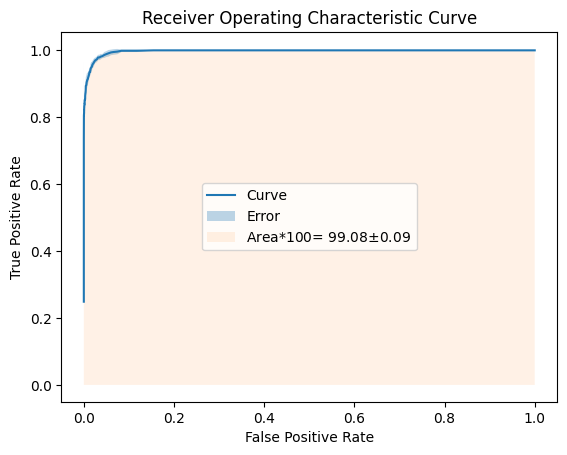

In [46]:
plt.plot(mean_roc[:,0],mean_roc[:,1],label = "Curve")
plt.fill_between(
    mean_roc[:, 0],
    mean_roc[:, 1] - error_roc[:, 1],
    mean_roc[:, 1] + error_roc[:, 1],
    alpha=0.3,
    label = "Error"
)
plt.fill_between(
    mean_roc[:, 0],
    0,
    mean_roc[:, 1],
    alpha=0.1,
    label=f"Area*100= 99.08$\pm$0.09",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend()
plt.savefig("ROC.png")
plt.show()

In [38]:
np.mean(auc_all_array)

np.float64(0.9865313649177552)